<a href="https://colab.research.google.com/github/AditeyaAItronics/devsoc-bits/blob/main/neural_style_transfer/style_transfer_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧠 Neural Style Transfer using VGG-19

In this task, you’ll implement **Neural Style Transfer (NST)** using a **pre-trained VGG-19** model. This will help you deepen your understanding of convolutional neural networks (CNNs), feature extraction, and how deep learning can be used for image generation.

---

### ✅ Objectives

- Build a Neural Style Transfer pipeline using **VGG-19**.
- Use only the **first convolutional layer** from **each of the five convolutional blocks** in VGG-19.
    - These layers strike a balance between general texture features and higher-level abstraction.
    - Deeper layers become too specialized for object recognition and are less effective for capturing style.

---

### ⚙️ System Requirements

VGG-19 is a **computationally heavy** model. If your system struggles to run it:

- Use **Google Collab** to access free GPU resources.
- This will allow faster computation and smoother experimentation.

### 📄 Reference Paper

We’ve linked the paper on **CNN-based image style transformation** below.

It uses VGG-19 and provides insight into the theory behind NST.

> 🔗 https://drive.google.com/file/d/1Dbxaazv-L2SbC3gY4cPlqOQmM2iGmwyB/view
>

Please read it carefully—it will help you understand what’s going on inside the model and how different layers contribute to the stylization process.

## Implementation thought process

- Load Pre-trained VGG-19
 Use a pre-trained VGG-19 model from PyTorch (torchvision.models.vgg19(pretrained=True)) or TensorFlow (tf.keras.applications.VGG19).
 Set the model to evaluation mode and freeze its weights.

- Select the First Conv Layer from Each Block
 In VGG-19, the first convolutional layers of the five blocks are typically named: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1. Extract outputs from these layers for style and content representations.

- Build the NST Pipeline

  - Preprocess Images: Resize, normalize, and convert images to tensors.
  - Extract Features: Pass the content and style images through the model, capturing activations from the selected layers.
  - Compute Losses:
     - Content Loss: Usually from conv4_1.
     - Style Loss: Use Gram matrices from all five selected layers.
- Optimization: Start with the content image (or white noise) and iteratively update it to minimize the combined loss.

## NST Pipeline

Key functionalities:
- Image loading and transformation using PyTorch and the VGG19 model.
- Feature extraction from different layers of the VGG19 model.
- Gram matrix calculation for capturing style representation.
- Content and style loss functions for iteratively updating a target image during style transfer.

Functions:
- load_image(img_path, max_size=400, shape=None): Load and transform an image.
- im_convert(tensor): Convert a PyTorch tensor to a NumPy image.
- display_content_and_style_images(content, style): Display the content and style images side-by-side.
- print_vgg_layers(vgg): Print the layers of the VGG model.
- get_features(image, model, layers=None): Extract features from a model.
- gram_matrix(tensor): Calculate the Gram Matrix of a given tensor.
- display_target_image(content, target): Display the target image along with the content image.
- image_style_transfer(vgg, content, style, device): Perform style transfer on the content image using the style image.
- main(): Main function for executing the PyTorch Style Transfer project.

In [ ]:
!git clone https://github.com/AditeyaAItronics/devsoc-bits

In [63]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [64]:
# import resources
import os
from PIL import Image  # Import the Image class from the PIL library for image processing
from io import BytesIO  # Import BytesIO for handling input/output streams
import matplotlib.pyplot as plt  # Import pyplot for plotting
import numpy as np  # Import NumPy for numerical computing

import torch  # Import PyTorch
import torch.optim as optim  # Import the optimization module from PyTorch
import requests  # Import the requests library for making HTTP requests
from torchvision import transforms, models  # Import transforms and models from torchvision for computer vision
from typing import Optional, Tuple  # Import type hints

In [66]:
def load_image(img_path: str, max_size: int = 400, shape: Optional[Tuple[int, int]] = None) -> torch.Tensor:
    """Load and transform an image."""
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')  # Open and convert the image to RGB format
    else:
        image = Image.open(img_path).convert('RGB')  # Open and convert the image to RGB format

    size = max_size if max(image.size) > max_size else max(image.size)
    size = shape if shape is not None else size

    in_transform = transforms.Compose([
        transforms.Resize(size),  # Resize the image
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])  # Apply normalization

    image = in_transform(image)[:3, :, :].unsqueeze(0)  # Normalize, discard alpha channel, and add batch dimension
    return image

In [67]:
def im_convert(tensor: torch.Tensor) -> np.ndarray:
    """Convert a PyTorch tensor to a NumPy image."""
    image = tensor.to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0)  # Convert tensor to NumPy array
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # Reverse normalization
    image = image.clip(0, 1)  # Clip values to the valid range [0, 1]
    return image


In [68]:
def display_content_and_style_images(content: torch.Tensor, style: torch.Tensor) -> None:
    """Display the content and style images side-by-side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # Create a subplot with two axes
    ax1.imshow(im_convert(content))  # Display the content image
    ax2.imshow(im_convert(style))  # Display the style image
    plt.show()

In [69]:
def print_vgg_layers(vgg: torch.nn.Module) -> None:
    """Print the layers of the VGG model."""
    print(vgg)  # Print the VGG model

In [19]:
## layer selection
# The indices of the layers we want to use for feature extraction
selected_layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'}

In [70]:
def get_features(image: torch.Tensor, model: torch.nn.Module, layers: Optional[dict] = None) -> dict:
    """Extract features from a model."""
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x  # Store the features for specified layers
    return features

In [71]:
def gram_matrix(tensor: torch.Tensor) -> torch.Tensor:
    """Calculate the Gram Matrix of a given tensor."""
    b, d, h, w = tensor.size()
    tensor = tensor.view(b * d, h * w)  # Flatten the tensor
    gram = torch.mm(tensor, tensor.t())  # Calculate the Gram Matrix
    return gram

In [72]:
def display_target_image(content: torch.Tensor, target: torch.Tensor) -> None:
    """Display the target image along with the content image side-by-side and save the target image."""
    output_dir = "images"
    filename = "final_comparison_2000.png"
    import os
    os.makedirs('images', exist_ok=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # Create a subplot with two axes
    ax1.imshow(im_convert(content))  # Display the content image
    ax2.imshow(im_convert(target))  # Display the target image

    # Save the target image to the output directory
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path)
    plt.show()

In [73]:
def image_style_transfer(vgg: torch.nn.Module, content: torch.Tensor, style: torch.Tensor,
                         device: torch.device) -> None:
    """Perform style transfer on the content image using the style image."""
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    target = content.clone().requires_grad_(True).to(device)  # Clone content image for stylization
    style_weights = {'conv1_1': 1., 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
    content_weight = 1  # Content loss weight (alpha)
    style_weight = 1e6  # Style loss weight (beta)
    show_every = 400  # Show intermediate results every 400 iterations
    optimizer = optim.Adam([target], lr=0.003)  # Adam optimizer for target image optimization
    steps = 2000  # Number of optimization steps

    for ii in range(1, steps + 1):
        target_features = get_features(target, vgg)
        content_loss = torch.mean(
            (target_features['conv4_2'] - content_features['conv4_2']) ** 2)  # Calculate content loss

        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
            style_loss += layer_style_loss / (d * h * w)  # Accumulate style loss for each layer
            print(f"For layer: {layer} loss is: {style_loss}")

        total_loss = content_weight * content_loss + style_weight * style_loss  # Calculate total loss
        print(f"for ii: {ii} total_loss is: {total_loss}")

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if ii % show_every == 0:
            print('Total loss: ', total_loss.item())
            plt.imshow(im_convert(target))
            plt.show()

    display_target_image(content, target)

For layer: conv1_1 loss is: 20.209157943725586
For layer: conv2_1 loss is: 79.39952850341797
For layer: conv3_1 loss is: 101.9593505859375
For layer: conv4_1 loss is: 105.01021575927734
For layer: conv5_1 loss is: 105.1404037475586
for ii: 1 total_loss is: 105140400.0
For layer: conv1_1 loss is: 20.1087589263916
For layer: conv2_1 loss is: 74.69168090820312
For layer: conv3_1 loss is: 96.076416015625
For layer: conv4_1 loss is: 98.95406341552734
For layer: conv5_1 loss is: 99.07750701904297
for ii: 2 total_loss is: 99077504.0
For layer: conv1_1 loss is: 20.001676559448242
For layer: conv2_1 loss is: 70.46675109863281
For layer: conv3_1 loss is: 90.77803039550781
For layer: conv4_1 loss is: 93.51286315917969
For layer: conv5_1 loss is: 93.63024139404297
for ii: 3 total_loss is: 93630240.0
For layer: conv1_1 loss is: 19.888423919677734
For layer: conv2_1 loss is: 66.6829833984375
For layer: conv3_1 loss is: 86.02285766601562
For layer: conv4_1 loss is: 88.64454650878906
For layer: conv5_

For layer: conv1_1 loss is: 1.3307442665100098
For layer: conv2_1 loss is: 2.019137382507324
For layer: conv3_1 loss is: 2.4909019470214844
For layer: conv4_1 loss is: 2.7560698986053467
For layer: conv5_1 loss is: 2.7664973735809326
for ii: 401 total_loss is: 2766503.5
For layer: conv1_1 loss is: 1.3268095254898071
For layer: conv2_1 loss is: 2.013032913208008
For layer: conv3_1 loss is: 2.483351469039917
For layer: conv4_1 loss is: 2.747957944869995
For layer: conv5_1 loss is: 2.758375883102417
for ii: 402 total_loss is: 2758382.25
For layer: conv1_1 loss is: 1.3228968381881714
For layer: conv2_1 loss is: 2.0069642066955566
For layer: conv3_1 loss is: 2.4758424758911133
For layer: conv4_1 loss is: 2.739889621734619
For layer: conv5_1 loss is: 2.750298261642456
for ii: 403 total_loss is: 2750304.5
For layer: conv1_1 loss is: 1.3190053701400757
For layer: conv2_1 loss is: 2.0009284019470215
For layer: conv3_1 loss is: 2.4683728218078613
For layer: conv4_1 loss is: 2.7318639755249023
Fo

For layer: conv1_1 loss is: 0.5508459210395813
For layer: conv2_1 loss is: 0.8253742456436157
For layer: conv3_1 loss is: 1.026737928390503
For layer: conv4_1 loss is: 1.1749485731124878
For layer: conv5_1 loss is: 1.1832026243209839
for ii: 801 total_loss is: 1183209.625
For layer: conv1_1 loss is: 0.5498495697975159
For layer: conv2_1 loss is: 0.8238908052444458
For layer: conv3_1 loss is: 1.0249472856521606
For layer: conv4_1 loss is: 1.1730071306228638
For layer: conv5_1 loss is: 1.1812578439712524
for ii: 802 total_loss is: 1181264.875
For layer: conv1_1 loss is: 0.5488556623458862
For layer: conv2_1 loss is: 0.8224115967750549
For layer: conv3_1 loss is: 1.0231614112854004
For layer: conv4_1 loss is: 1.1710712909698486
For layer: conv5_1 loss is: 1.1793184280395508
for ii: 803 total_loss is: 1179325.375
For layer: conv1_1 loss is: 0.5478642582893372
For layer: conv2_1 loss is: 0.8209353685379028
For layer: conv3_1 loss is: 1.0213793516159058
For layer: conv4_1 loss is: 1.16913974

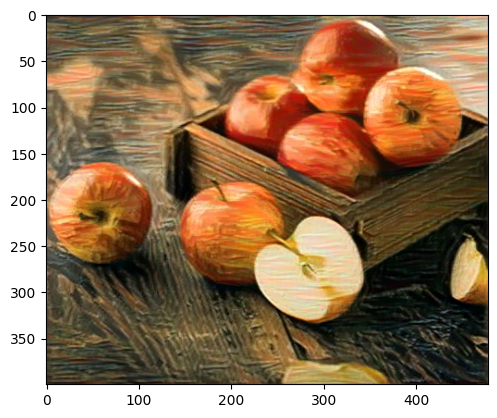

For layer: conv1_1 loss is: 0.2946118414402008
For layer: conv2_1 loss is: 0.443989634513855
For layer: conv3_1 loss is: 0.5644593834877014
For layer: conv4_1 loss is: 0.6707748770713806
For layer: conv5_1 loss is: 0.6779550909996033
for ii: 1201 total_loss is: 677962.5
For layer: conv1_1 loss is: 0.2942189872264862
For layer: conv2_1 loss is: 0.443398118019104
For layer: conv3_1 loss is: 0.5637363195419312
For layer: conv4_1 loss is: 0.6699771285057068
For layer: conv5_1 loss is: 0.6771551966667175
for ii: 1202 total_loss is: 677162.625
For layer: conv1_1 loss is: 0.29382720589637756
For layer: conv2_1 loss is: 0.4428081512451172
For layer: conv3_1 loss is: 0.5630150437355042
For layer: conv4_1 loss is: 0.6691814064979553
For layer: conv5_1 loss is: 0.6763572692871094
for ii: 1203 total_loss is: 676364.6875
For layer: conv1_1 loss is: 0.29343611001968384
For layer: conv2_1 loss is: 0.44221943616867065
For layer: conv3_1 loss is: 0.5622953772544861
For layer: conv4_1 loss is: 0.6683870

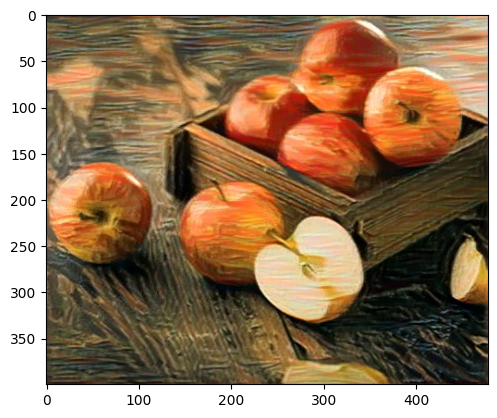

For layer: conv1_1 loss is: 0.1850547045469284
For layer: conv2_1 loss is: 0.27679160237312317
For layer: conv3_1 loss is: 0.35818058252334595
For layer: conv4_1 loss is: 0.44129276275634766
For layer: conv5_1 loss is: 0.4476759135723114
for ii: 1601 total_loss is: 447683.59375
For layer: conv1_1 loss is: 0.1848657727241516
For layer: conv2_1 loss is: 0.2765006422996521
For layer: conv3_1 loss is: 0.35781794786453247
For layer: conv4_1 loss is: 0.4408852458000183
For layer: conv5_1 loss is: 0.4472666084766388
for ii: 1602 total_loss is: 447274.28125
For layer: conv1_1 loss is: 0.18467704951763153
For layer: conv2_1 loss is: 0.27621009945869446
For layer: conv3_1 loss is: 0.3574557304382324
For layer: conv4_1 loss is: 0.4404781460762024
For layer: conv5_1 loss is: 0.4468577206134796
for ii: 1603 total_loss is: 446865.40625
For layer: conv1_1 loss is: 0.18448863923549652
For layer: conv2_1 loss is: 0.27592021226882935
For layer: conv3_1 loss is: 0.35709428787231445
For layer: conv4_1 los

FileNotFoundError: [Errno 2] No such file or directory: 'images/final_comparison_2000.png'

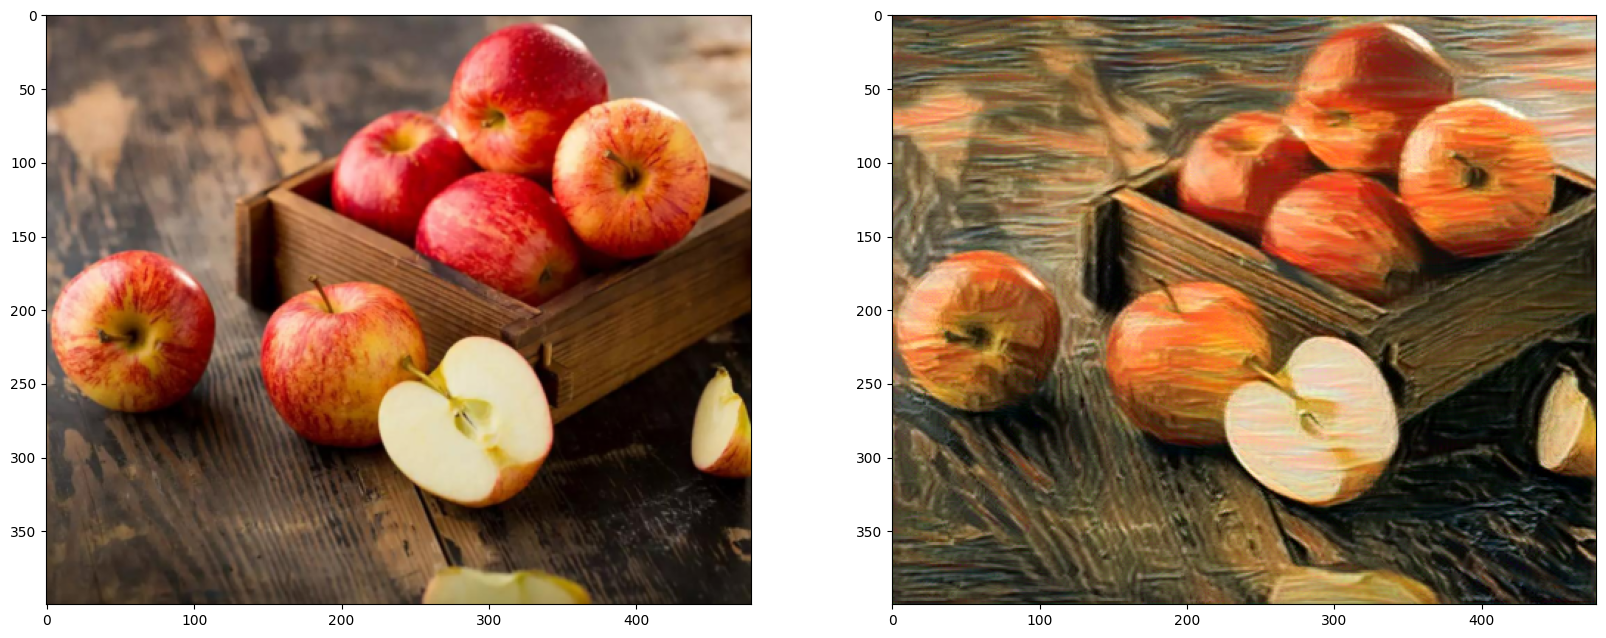

In [74]:
    vgg = models.vgg19(weights='VGG19_Weights.DEFAULT').features
    for param in vgg.parameters():
        param.requires_grad_(False)  # Freeze all VGG parameters

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vgg.to(device)

    content = load_image('/content/devsoc-bits/neural_style_transfer/images/test_images/apple.jpg').to(device)
    style = load_image('/content/devsoc-bits/neural_style_transfer/images/style/scream.jpg', shape=content.shape[-2:]).to(device)

    image_style_transfer(vgg, content, style, device)


fatal: destination path 'devsoc-bits' already exists and is not an empty directory.


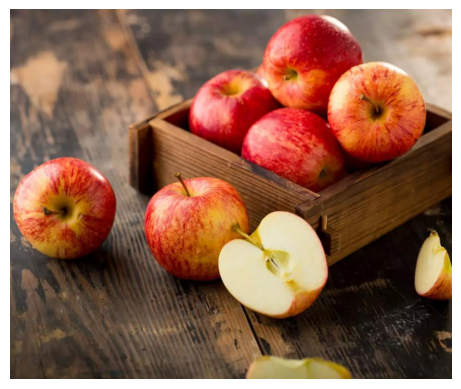

In [60]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(image_path):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

show_image('/content/devsoc-bits/neural_style_transfer/images/test_images/apple.jpg')

In [61]:
show_image('/content/output.png')

In [62]:
show_image('/content/devsoc-bits/neural_style_transfer/images/style/scream.jpg')